In [1]:
import os
import os.path as path
import gc
import re
import math
import json

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [5]:
pd.set_option('display.max_row', 50)
pd.set_option('display.max_columns', 100)

In [6]:
# 디렉토리 기본 경로 설정
DIR_PATH = path.join('..')
DIR_SAVE_PATH = path.join('.')

print(DIR_PATH)
print(DIR_SAVE_PATH)

..
.


In [7]:
# bean_raw_data.csv
user_read = pd.read_csv(path.join(DIR_PATH, 'user_propensity_data.csv'), low_memory=False)

print(user_read.shape)
user_read.columns = ['timestamp', 'phone', 'cafe', 'preference', 'drink', 'dessert', 'fruit', 'aroma']
user_read.head()

(105, 8)


timestamp          phone                    cafe  \
0  2023. 3. 24 오후 2:59:41  010-9491-7668          스타벅스 Starbucks   
1  2023. 3. 24 오후 3:03:33  010-2840-2336          스타벅스 Starbucks   
2  2023. 3. 24 오후 3:03:50  010-9231-9670  투썸플레이스 A TWOSOME PLACE   
3  2023. 3. 24 오후 3:04:09  010-9027-0157     이디야 커피 EDIYA COFFEE   
4  2023. 3. 24 오후 3:04:13  010-4404-9238          스타벅스 Starbucks   

               preference                            drink          dessert  \
0   향이나 맛이 다른 커피보다 잘 느껴져요            ☕에스프레소 또는 아메리카노, 콜드브루   진하고 달달한 초코 케이크   
1   다른 커피를 마실때보다 목넘김이 좋아요  🍯카페모카 또는 바닐라라떼, 카라멜 마키아또 (달달해요)   진하고 달달한 초코 케이크   
2   향이나 맛이 다른 커피보다 잘 느껴져요            ☕에스프레소 또는 아메리카노, 콜드브루  상큼하고 개운한 과일 타르트   
3   다른 커피를 마실때보다 목넘김이 좋아요            ☕에스프레소 또는 아메리카노, 콜드브루   진하고 달달한 초코 케이크   
4  설탕이나 초콜릿 냄새라던가 맛이 선명해요  🍯카페모카 또는 바닐라라떼, 카라멜 마키아또 (달달해요)  상큼하고 개운한 과일 타르트   

        fruit            aroma  
0     체리, 복숭아  허브의 마음이 진정되는 향기  
1       사과, 배  꿀이나 설탕같은 달달한 향기  
2  크랜베리, 블루베리  허브의 마음이 진정되는 향기  
3  레몬, 오렌지, 귤       나무의 우디한 향기  
4       사과, 배        꽃의 신선한 향기

In [8]:
user_data = user_read.iloc[:, 2:].copy()
user_data

cafe              preference  \
0            스타벅스 Starbucks   향이나 맛이 다른 커피보다 잘 느껴져요   
1            스타벅스 Starbucks   다른 커피를 마실때보다 목넘김이 좋아요   
2    투썸플레이스 A TWOSOME PLACE   향이나 맛이 다른 커피보다 잘 느껴져요   
3       이디야 커피 EDIYA COFFEE   다른 커피를 마실때보다 목넘김이 좋아요   
4            스타벅스 Starbucks  설탕이나 초콜릿 냄새라던가 맛이 선명해요   
..                      ...                     ...   
100                     컴포즈        커피의 새콤한 맛이 도드라져요   
101     이디야 커피 EDIYA COFFEE    커피 특유의 씁쓸한 맛이 잘 나타나요   
102  카페 파스쿠치 CAFFÉ PASCUCCI   다른 커피를 마실때보다 목넘김이 좋아요   
103  투썸플레이스 A TWOSOME PLACE        커피의 새콤한 맛이 도드라져요   
104          스타벅스 Starbucks   향이나 맛이 다른 커피보다 잘 느껴져요   

                               drink               dessert          fruit  \
0              ☕에스프레소 또는 아메리카노, 콜드브루        진하고 달달한 초코 케이크        체리, 복숭아   
1    🍯카페모카 또는 바닐라라떼, 카라멜 마키아또 (달달해요)        진하고 달달한 초코 케이크          사과, 배   
2              ☕에스프레소 또는 아메리카노, 콜드브루       상큼하고 개운한 과일 타르트     크랜베리, 블루베리   
3              ☕에스프레소 또는 아메리카노, 콜드브루        진하고 달달한 초코 케이크     레몬, 오렌지, 귤   
4    🍯카페모카 또는 바닐라라떼, 카라멜 마키아또 (달달해요)       상큼하고 개운한 과일 타르트          사과, 배   
..                               ...                   ...            ...   
100            ☕에스프레소 또는 아메리카노, 콜드브루        진하고 달달한 초코 케이크     레몬, 오렌지, 귤   
101            ☕에스프레소 또는 아메리카노, 콜드브루       상큼하고 개운한 과일 타르트     레몬, 오렌지, 귤   
102            ☕에스프레소 또는 아메리카노, 콜드브루        진하고 달달한 초코 케이크     크랜베리, 블루베리   
103            ☕에스프레소 또는 아메리카노, 콜드브루  담백하고 고소한이 두드러지는 호두파이  망고, 바나나, 파인애플   
104  🍯카페모카 또는 바닐라라떼, 카라멜 마키아또 (달달해요)  담백하고 고소한이 두드러지는 호두파이     레몬, 오렌지, 귤   

               aroma  
0    허브의 마음이 진정되는 향기  
1    꿀이나 설탕같은 달달한 향기  
2    허브의 마음이 진정되는 향기  
3         나무의 우디한 향기  
4          꽃의 신선한 향기  
..               ...  
100        꽃의 신선한 향기  
101       나무의 우디한 향기  
102       나무의 우디한 향기  
103  허브의 마음이 진정되는 향기  
104        꽃의 신선한 향기  

[105 rows x 6 columns]

In [9]:
user_data.loc[(user_data['cafe'] != '스타벅스 Starbucks') \
& (user_data['cafe'] != '투썸플레이스 A TWOSOME PLACE') \
& (user_data['cafe'] != '이디야 커피 EDIYA COFFEE') \
& (user_data['cafe'] != '카페 파스쿠치 CAFFÉ PASCUCCI'), 'cafe'] = "_기타"
user_data

cafe              preference  \
0            스타벅스 Starbucks   향이나 맛이 다른 커피보다 잘 느껴져요   
1            스타벅스 Starbucks   다른 커피를 마실때보다 목넘김이 좋아요   
2    투썸플레이스 A TWOSOME PLACE   향이나 맛이 다른 커피보다 잘 느껴져요   
3       이디야 커피 EDIYA COFFEE   다른 커피를 마실때보다 목넘김이 좋아요   
4            스타벅스 Starbucks  설탕이나 초콜릿 냄새라던가 맛이 선명해요   
..                      ...                     ...   
100                     _기타        커피의 새콤한 맛이 도드라져요   
101     이디야 커피 EDIYA COFFEE    커피 특유의 씁쓸한 맛이 잘 나타나요   
102  카페 파스쿠치 CAFFÉ PASCUCCI   다른 커피를 마실때보다 목넘김이 좋아요   
103  투썸플레이스 A TWOSOME PLACE        커피의 새콤한 맛이 도드라져요   
104          스타벅스 Starbucks   향이나 맛이 다른 커피보다 잘 느껴져요   

                               drink               dessert          fruit  \
0              ☕에스프레소 또는 아메리카노, 콜드브루        진하고 달달한 초코 케이크        체리, 복숭아   
1    🍯카페모카 또는 바닐라라떼, 카라멜 마키아또 (달달해요)        진하고 달달한 초코 케이크          사과, 배   
2              ☕에스프레소 또는 아메리카노, 콜드브루       상큼하고 개운한 과일 타르트     크랜베리, 블루베리   
3              ☕에스프레소 또는 아메리카노, 콜드브루        진하고 달달한 초코 케이크     레몬, 오렌지, 귤   
4    🍯카페모카 또는 바닐라라떼, 카라멜 마키아또 (달달해요)       상큼하고 개운한 과일 타르트          사과, 배   
..                               ...                   ...            ...   
100            ☕에스프레소 또는 아메리카노, 콜드브루        진하고 달달한 초코 케이크     레몬, 오렌지, 귤   
101            ☕에스프레소 또는 아메리카노, 콜드브루       상큼하고 개운한 과일 타르트     레몬, 오렌지, 귤   
102            ☕에스프레소 또는 아메리카노, 콜드브루        진하고 달달한 초코 케이크     크랜베리, 블루베리   
103            ☕에스프레소 또는 아메리카노, 콜드브루  담백하고 고소한이 두드러지는 호두파이  망고, 바나나, 파인애플   
104  🍯카페모카 또는 바닐라라떼, 카라멜 마키아또 (달달해요)  담백하고 고소한이 두드러지는 호두파이     레몬, 오렌지, 귤   

               aroma  
0    허브의 마음이 진정되는 향기  
1    꿀이나 설탕같은 달달한 향기  
2    허브의 마음이 진정되는 향기  
3         나무의 우디한 향기  
4          꽃의 신선한 향기  
..               ...  
100        꽃의 신선한 향기  
101       나무의 우디한 향기  
102       나무의 우디한 향기  
103  허브의 마음이 진정되는 향기  
104        꽃의 신선한 향기  

[105 rows x 6 columns]

In [10]:
cafe_list = np.sort(user_data['cafe'].unique()).tolist()
print(cafe_list)

if 'cafe_label' in user_data:
    user_data.drop(labels=['cafe_label'], axis=1, inplace=True)

# user_data.insert(int(user_data.columns.get_indexer(['cafe'])[0] + 1), 'cafe_label', user_data['cafe'].map(lambda x: cafe_list.index(x)), )
user_data.insert(len(user_data.columns), 'cafe_label', user_data['cafe'].map(lambda x: cafe_list.index(x)))

['_기타', '스타벅스 Starbucks', '이디야 커피 EDIYA COFFEE', '카페 파스쿠치 CAFFÉ PASCUCCI', '투썸플레이스 A TWOSOME PLACE']


In [11]:
preference_list = np.sort(user_data['preference'].unique()).tolist()
print(preference_list)

if 'preference_label' in user_data:
    user_data.drop(labels=['preference_label'], axis=1, inplace=True)

user_data.insert(len(user_data.columns), 'preference_label', user_data['preference'].map(lambda x: preference_list.index(x)))

['다른 커피를 마실때보다 목넘김이 좋아요', '설탕이나 초콜릿 냄새라던가 맛이 선명해요', '커피 특유의 씁쓸한 맛이 잘 나타나요', '커피의 새콤한 맛이 도드라져요', '향이나 맛이 다른 커피보다 잘 느껴져요']


In [12]:
drink_list = np.sort(user_data['drink'].unique()).tolist()
print(drink_list)

if 'drink_label' in user_data:
    user_data.drop(labels=['drink_label'], axis=1, inplace=True)

user_data.insert(len(user_data.columns), 'drink_label', user_data['drink'].map(lambda x: drink_list.index(x)))

['☕에스프레소 또는 아메리카노, 콜드브루', '🌸티 또는 주스', '🍯카페모카 또는 바닐라라떼, 카라멜 마키아또 (달달해요)', '🥛카페라떼 또는 카푸치노, 마끼아또 (달지않아요)']


In [13]:
dessert_list = np.sort(user_data['dessert'].unique()).tolist()
print(dessert_list)

if 'dessert_label' in user_data:
    user_data.drop(labels=['dessert_label'], axis=1, inplace=True)

user_data.insert(len(user_data.columns), 'dessert_label', user_data['dessert'].map(lambda x: dessert_list.index(x)))

['담백하고 고소한이 두드러지는 호두파이', '상큼하고 개운한 과일 타르트', '진하고 달달한 초코 케이크']


In [14]:
fruit_list = np.sort(user_data['fruit'].unique()).tolist()
print(fruit_list)

if 'fruit_label' in user_data:
    user_data.drop(labels=['fruit_label'], axis=1, inplace=True)

user_data.insert(len(user_data.columns), 'fruit_label', user_data['fruit'].map(lambda x: fruit_list.index(x)))

['레몬, 오렌지, 귤', '망고, 바나나, 파인애플', '사과, 배', '체리, 복숭아', '크랜베리, 블루베리']


In [15]:
aroma_list = np.sort(user_data['aroma'].unique()).tolist()
print(aroma_list)

if 'aroma_label' in user_data:
    user_data.drop(labels=['aroma_label'], axis=1, inplace=True)

user_data.insert(len(user_data.columns), 'aroma_label', user_data['aroma'].map(lambda x: aroma_list.index(x)))

['감귤의 상큼한 향기', '꽃의 신선한 향기', '꿀이나 설탕같은 달달한 향기', '나무의 우디한 향기', '허브의 마음이 진정되는 향기']


In [16]:
user_data.head()

cafe              preference  \
0          스타벅스 Starbucks   향이나 맛이 다른 커피보다 잘 느껴져요   
1          스타벅스 Starbucks   다른 커피를 마실때보다 목넘김이 좋아요   
2  투썸플레이스 A TWOSOME PLACE   향이나 맛이 다른 커피보다 잘 느껴져요   
3     이디야 커피 EDIYA COFFEE   다른 커피를 마실때보다 목넘김이 좋아요   
4          스타벅스 Starbucks  설탕이나 초콜릿 냄새라던가 맛이 선명해요   

                             drink          dessert       fruit  \
0            ☕에스프레소 또는 아메리카노, 콜드브루   진하고 달달한 초코 케이크     체리, 복숭아   
1  🍯카페모카 또는 바닐라라떼, 카라멜 마키아또 (달달해요)   진하고 달달한 초코 케이크       사과, 배   
2            ☕에스프레소 또는 아메리카노, 콜드브루  상큼하고 개운한 과일 타르트  크랜베리, 블루베리   
3            ☕에스프레소 또는 아메리카노, 콜드브루   진하고 달달한 초코 케이크  레몬, 오렌지, 귤   
4  🍯카페모카 또는 바닐라라떼, 카라멜 마키아또 (달달해요)  상큼하고 개운한 과일 타르트       사과, 배   

             aroma  cafe_label  preference_label  drink_label  dessert_label  \
0  허브의 마음이 진정되는 향기           1                 4            0              2   
1  꿀이나 설탕같은 달달한 향기           1                 0            2              2   
2  허브의 마음이 진정되는 향기           4                 4            0              1   
3       나무의 우디한 향기           2                 0            0              2   
4        꽃의 신선한 향기           1                 1            2              1   

   fruit_label  aroma_label  
0            3            4  
1            2            2  
2            4            4  
3            0            3  
4            2            1

In [17]:
user_label = user_data.iloc[:, 6:].copy()
user_label.head()

cafe_label  preference_label  drink_label  dessert_label  fruit_label  \
0           1                 4            0              2            3   
1           1                 0            2              2            2   
2           4                 4            0              1            4   
3           2                 0            0              2            0   
4           1                 1            2              1            2   

   aroma_label  
0            4  
1            2  
2            4  
3            3  
4            1

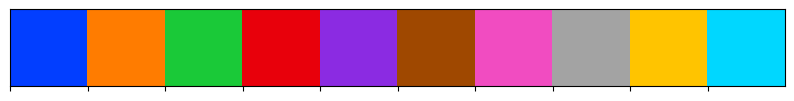

In [18]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.palplot(sns.color_palette("bright"))


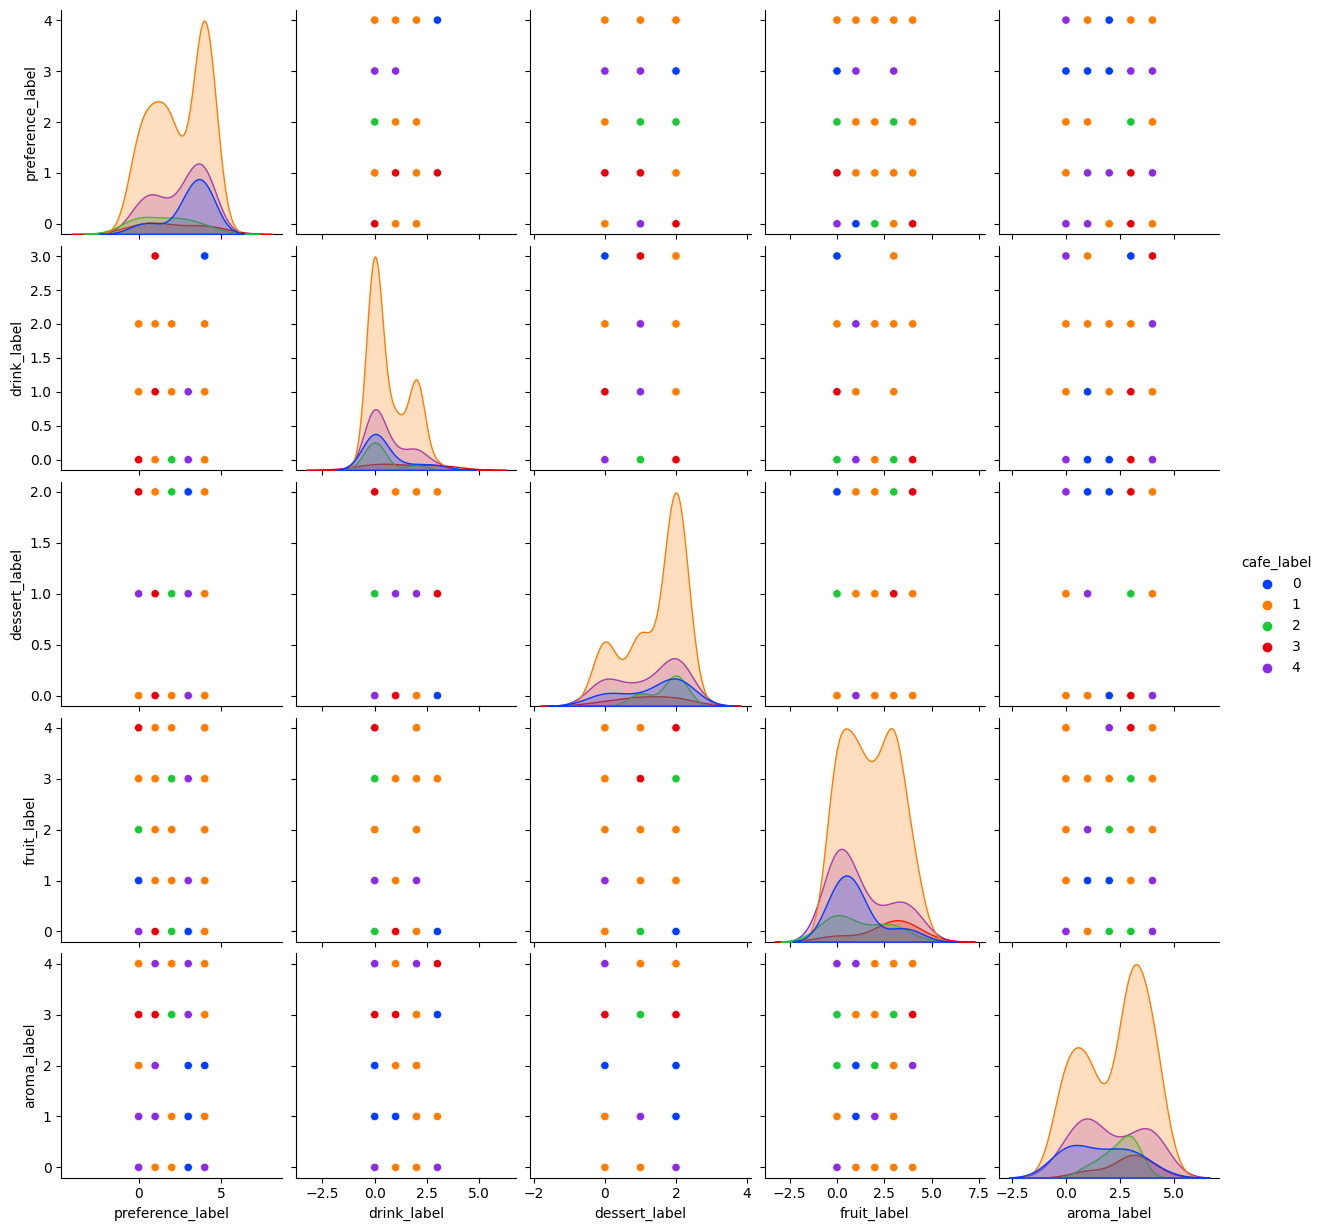

In [19]:
sns.pairplot(user_label, hue='cafe_label', palette='bright')

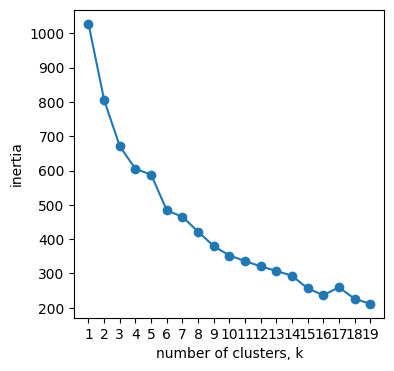

In [20]:
from sklearn.cluster import KMeans
# 적절한 군집수 찾기
# Inertia(군집 내 거리제곱합의 합) value (적정 군집수)

ks = range(1,20)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k, n_init='auto')
    model.fit(user_label)
    inertias.append(model.inertia_)

# Plot ks vs inertias
plt.figure(figsize=(4, 4))

plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [21]:
# K-Means 모델과 군집 예측값을 생성

# 클러스터 모델 생성 파라미터는 원할 경우 추가
clust_model = KMeans(n_clusters = 5, n_init='auto'
#                      , max_iter=500 # KMeans를 몇번 반복 수행할건지, K가 큰 경우 1000정도로 높여준다
#                      , random_state = 42
#                      , algorithm='auto'
                    )

# 생성한 모델로 데이터를 학습시킴
clust_model.fit(user_label) # unsupervised learning 

# 결과 값을 변수에 저장
centers = clust_model.cluster_centers_ # 각 군집의 중심점
pred = clust_model.predict(user_label) # 각 예측군집

print(pd.DataFrame(centers))
print(pred[:10])

          0         1         2         3         4         5
0  2.000000  1.956522  1.043478  1.260870  0.347826  0.608696
1  0.884615  3.423077  0.423077  1.076923  0.807692  3.346154
2  1.280000  0.680000  0.840000  1.800000  2.320000  2.520000
3  1.000000  3.882353  0.411765  1.470588  3.000000  1.352941
4  3.928571  2.928571  0.500000  1.357143  1.928571  3.071429
[1 2 4 2 2 1 1 3 2 1]


In [22]:
# 원래 데이터에 예측된 군집 붙이기
user_clust_df = user_label.copy()
user_clust_df['clust'] = pred
user_clust_df.head()

cafe_label  preference_label  drink_label  dessert_label  fruit_label  \
0           1                 4            0              2            3   
1           1                 0            2              2            2   
2           4                 4            0              1            4   
3           2                 0            0              2            0   
4           1                 1            2              1            2   

   aroma_label  clust  
0            4      1  
1            2      2  
2            4      4  
3            3      2  
4            1      2

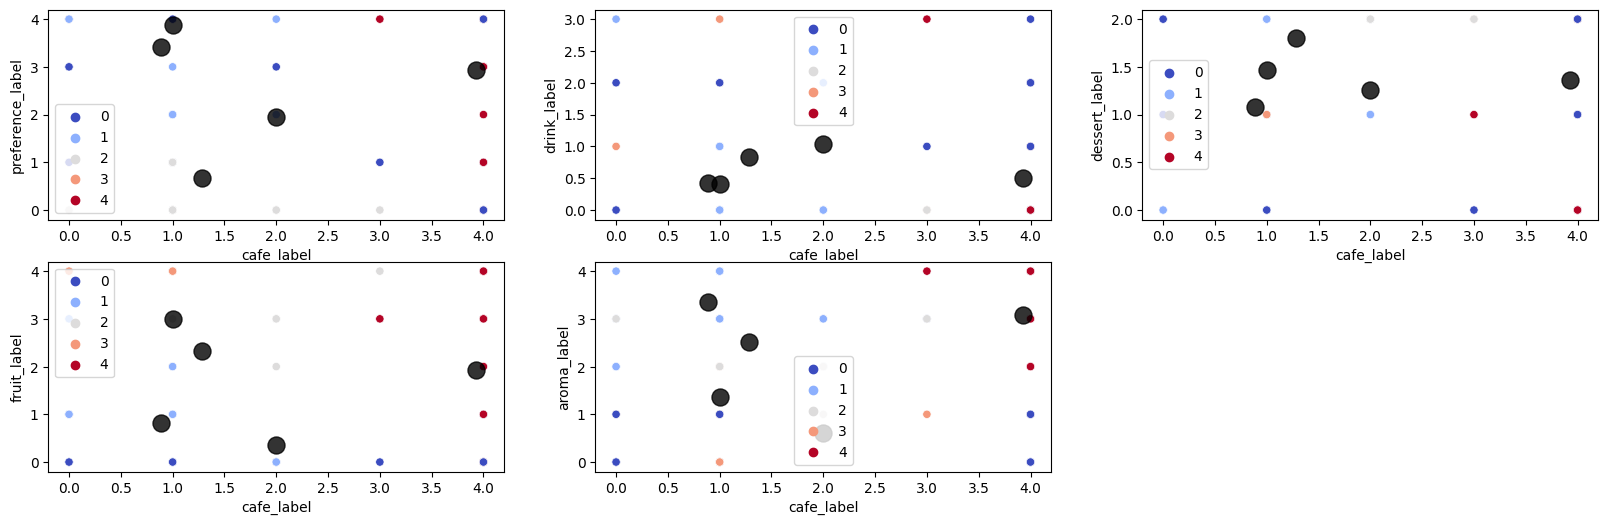

In [23]:
# scaling하지 않은 데이터를 학습하고 시각화하기

plt.figure(figsize=(20, 6))

X = user_clust_df

plt.subplot(231)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,1], data=user_label, hue=clust_model.labels_, palette='coolwarm')
plt.scatter(centers[:,0], centers[:,1], c='black', alpha=0.8, s=150)

plt.subplot(232)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,2], data=user_label, hue=clust_model.labels_, palette='coolwarm')
plt.scatter(centers[:,0], centers[:,2], c='black', alpha=0.8, s=150)

plt.subplot(233)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,3], data=user_label, hue=clust_model.labels_, palette='coolwarm')
plt.scatter(centers[:,0], centers[:,3], c='black', alpha=0.8, s=150)

plt.subplot(234)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,4], data=user_label, hue=clust_model.labels_, palette='coolwarm')
plt.scatter(centers[:,0], centers[:,4], c='black', alpha=0.8, s=150)

plt.subplot(235)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,5], data=user_label, hue=clust_model.labels_, palette='coolwarm')
plt.scatter(centers[:,0], centers[:,5], c='black', alpha=0.8, s=150)

plt.show()

In [24]:
cluster_mean = user_clust_df.groupby('clust').mean()
cluster_mean

cafe_label  preference_label  drink_label  dessert_label  fruit_label  \
clust                                                                          
0        2.000000          1.956522     1.043478       1.260870     0.347826   
1        0.884615          3.423077     0.423077       1.076923     0.807692   
2        1.280000          0.680000     0.840000       1.800000     2.320000   
3        1.000000          3.882353     0.411765       1.470588     3.000000   
4        3.928571          2.928571     0.500000       1.357143     1.928571   

       aroma_label  
clust               
0         0.608696  
1         3.346154  
2         2.520000  
3         1.352941  
4         3.071429

In [25]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
scaled_df = pd.DataFrame(standard_scaler.fit_transform(user_label.iloc[:,:]), columns=user_label.iloc[:,:].columns) # scaled된 데이터

In [26]:
# create model and prediction
# clust_model은 스케일링 전 fit과 동일하게 맞춤

clust_model.fit(scaled_df) # unsupervised learning #애초에 결과를 모르기 때문에 data만 넣어주면 됨

centers_s = clust_model.cluster_centers_
pred_s = clust_model.predict(scaled_df)

In [27]:
# 스케일링 전에 합쳐준 데이터프레임에 스케일한 군집 컬럼 추가하기
user_clust_df['clust_s'] = pred_s
user_clust_df

cafe_label  preference_label  drink_label  dessert_label  fruit_label  \
0             1                 4            0              2            3   
1             1                 0            2              2            2   
2             4                 4            0              1            4   
3             2                 0            0              2            0   
4             1                 1            2              1            2   
..          ...               ...          ...            ...          ...   
100           0                 3            0              2            0   
101           2                 2            0              1            0   
102           3                 0            0              2            4   
103           4                 3            0              0            1   
104           1                 4            2              0            0   

     aroma_label  clust  clust_s  
0              4      1        3  
1              2      2        0  
2              4      4        3  
3              3      2        4  
4              1      2        0  
..           ...    ...      ...  
100            1      0        1  
101            3      1        2  
102            3      2        4  
103            4      4        2  
104            1      0        1  

[105 rows x 8 columns]

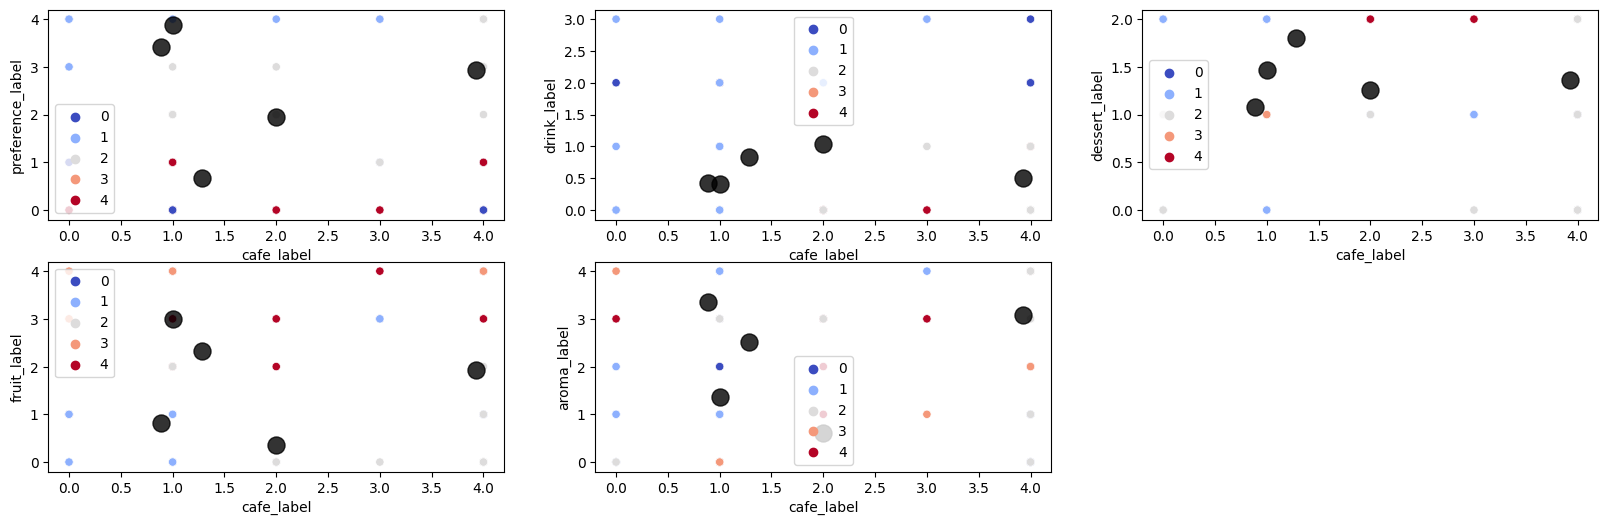

In [28]:
# scaling한 데이터를 학습하고 시각화하기

plt.figure(figsize=(20, 6))

X = user_clust_df

plt.subplot(231)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,1], data=user_label, hue=clust_model.labels_, palette='coolwarm')
plt.scatter(centers[:,0], centers[:,1], c='black', alpha=0.8, s=150)

plt.subplot(232)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,2], data=user_label, hue=clust_model.labels_, palette='coolwarm')
plt.scatter(centers[:,0], centers[:,2], c='black', alpha=0.8, s=150)

plt.subplot(233)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,3], data=user_label, hue=clust_model.labels_, palette='coolwarm')
plt.scatter(centers[:,0], centers[:,3], c='black', alpha=0.8, s=150)

plt.subplot(234)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,4], data=user_label, hue=clust_model.labels_, palette='coolwarm')
plt.scatter(centers[:,0], centers[:,4], c='black', alpha=0.8, s=150)

plt.subplot(235)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,5], data=user_label, hue=clust_model.labels_, palette='coolwarm')
plt.scatter(centers[:,0], centers[:,5], c='black', alpha=0.8, s=150)

plt.show()

In [29]:
weight_df = pd.DataFrame(columns=['flavor', 'acidity', 'sweetness', 'bitterness', 'body', 'balance'], dtype='float')
# weight_df = weight_df.astype({'coffeeing_note':'str'})
print(weight_df.dtypes)
weight_df.head()

flavor        float64
acidity       float64
sweetness     float64
bitterness    float64
body          float64
balance       float64
dtype: object


Empty DataFrame
Columns: [flavor, acidity, sweetness, bitterness, body, balance]
Index: []

In [30]:
survey_weight_df = []
for i in range(5):
    survey_weight_df.append(weight_df.copy())

In [31]:
survey_weight_df[0]

Empty DataFrame
Columns: [flavor, acidity, sweetness, bitterness, body, balance]
Index: []

In [32]:
survey_transform = np.array(
 # '_기타', '스타벅스', '이디야 커피', '카페 파스쿠치', '투썸플레이스'
[[[0, 0, 0, 0, 0, 0], [8, 4, 4, 9, 6, 6], [4, 8, 5, 6, 8, 4], [7, 10, 8, 6, 7, 6], [9, 5, 3, 7, 10, 7]], 
 # '바디', '단맛', '쓴맛', '산미', '향미'
 [[0, 0, 0, 0, 12, 6], [0, 0, 12, 0, 0, 6], [0, 0, 0, 12, 0, 6], [0, 12, 0, 0, 0, 6], [12, 0, 0, 0, 0, 6]], 
 # '블랙', '티/주스', '단 음료', '우유 첨가 음료'
 [[12, 7, 4, 10, 9, 6], [11, 5, 11, 1, 4, 4], [8, 2, 12, 2, 6, 5], [7, 3, 7, 4, 11, 8], [0, 0, 0, 0, 0, 0]], 
 # '호두파이', '과일 타르트', '초코 케이크'
 [[7, 0, 4, 7, 10, 5], [9, 5, 8, 2, 4, 7], [5, 1, 10, 4, 9, 4], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]], 
 # '레몬, 오렌지, 귤', '망고, 바나나, 파인애플', '사과, 배', '체리, 복숭아', '크랜베리, 블루베리'
 [[8, 12, 4, 6, 5, 6], [7, 5, 9, 4, 10, 5], [6, 6, 7, 2, 3, 10], [12, 3, 10, 3, 2, 5], [5, 8, 6, 9, 4, 4]], 
 # '시트러스', '플로럴', '슈가/허니', '우디', '허브'
 [[8, 10, 4, 1, 5, 3], [10, 3, 3, 3, 4, 8], [9, 0, 10, 0, 6, 5], [5, 1, 1, 9, 10, 4], [11, 2, 2, 3, 5, 6]]])
survey_transform

array([[[ 0,  0,  0,  0,  0,  0],
        [ 8,  4,  4,  9,  6,  6],
        [ 4,  8,  5,  6,  8,  4],
        [ 7, 10,  8,  6,  7,  6],
        [ 9,  5,  3,  7, 10,  7]],

       [[ 0,  0,  0,  0, 12,  6],
        [ 0,  0, 12,  0,  0,  6],
        [ 0,  0,  0, 12,  0,  6],
        [ 0, 12,  0,  0,  0,  6],
        [12,  0,  0,  0,  0,  6]],

       [[12,  7,  4, 10,  9,  6],
        [11,  5, 11,  1,  4,  4],
        [ 8,  2, 12,  2,  6,  5],
        [ 7,  3,  7,  4, 11,  8],
        [ 0,  0,  0,  0,  0,  0]],

       [[ 7,  0,  4,  7, 10,  5],
        [ 9,  5,  8,  2,  4,  7],
        [ 5,  1, 10,  4,  9,  4],
        [ 0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0]],

       [[ 8, 12,  4,  6,  5,  6],
        [ 7,  5,  9,  4, 10,  5],
        [ 6,  6,  7,  2,  3, 10],
        [12,  3, 10,  3,  2,  5],
        [ 5,  8,  6,  9,  4,  4]],

       [[ 8, 10,  4,  1,  5,  3],
        [10,  3,  3,  3,  4,  8],
        [ 9,  0, 10,  0,  6,  5],
        [ 5,  1,  1,  9, 10,  4],
    

In [33]:
user_label_tf_df = pd.DataFrame(columns=['flavor', 'acidity', 'sweetness', 'bitterness', 'body', 'balance'])
user_label_tf_df = user_label.copy()
user_label_tf_df

cafe_label  preference_label  drink_label  dessert_label  fruit_label  \
0             1                 4            0              2            3   
1             1                 0            2              2            2   
2             4                 4            0              1            4   
3             2                 0            0              2            0   
4             1                 1            2              1            2   
..          ...               ...          ...            ...          ...   
100           0                 3            0              2            0   
101           2                 2            0              1            0   
102           3                 0            0              2            4   
103           4                 3            0              0            1   
104           1                 4            2              0            0   

     aroma_label  
0              4  
1              2  
2              4  
3              3  
4              1  
..           ...  
100            1  
101            3  
102            3  
103            4  
104            1  

[105 rows x 6 columns]

In [34]:
survey_transform[0][1]

array([8, 4, 4, 9, 6, 6])

In [35]:
list(enumerate([x for x in user_label_tf_df.iloc[0, :]]))

[(0, 1), (1, 4), (2, 0), (3, 2), (4, 3), (5, 4)]

In [36]:
def label_transform(idx, matrix, transform):
    tf_sum = np.array([0,0,0,0,0,0])
    for i, j in list(enumerate([x for x in matrix.iloc[idx, :]])):
        tf_sum += transform[i][j]
        # print(transform[i][j])

    tf_mean = tf_sum / (6*6*2)
    # print(tf_mean)
    return tf_mean

In [37]:
pd.DataFrame(data=user_label_tf_df)

cafe_label  preference_label  drink_label  dessert_label  fruit_label  \
0             1                 4            0              2            3   
1             1                 0            2              2            2   
2             4                 4            0              1            4   
3             2                 0            0              2            0   
4             1                 1            2              1            2   
..          ...               ...          ...            ...          ...   
100           0                 3            0              2            0   
101           2                 2            0              1            0   
102           3                 0            0              2            4   
103           4                 3            0              0            1   
104           1                 4            2              0            0   

     aroma_label  
0              4  
1              2  
2              4  
3              3  
4              1  
..           ...  
100            1  
101            3  
102            3  
103            4  
104            1  

[105 rows x 6 columns]

In [38]:
user_label.loc[0].name

0

In [39]:
user_label.apply(lambda x: label_transform(x.name, user_label, survey_transform), axis=1)

0      [0.8333333333333334, 0.2361111111111111, 0.416...
1      [0.5, 0.18055555555555555, 0.5972222222222222,...
2      [0.8055555555555556, 0.375, 0.3194444444444444...
3      [0.4722222222222222, 0.4027777777777778, 0.333...
4      [0.5694444444444444, 0.2777777777777778, 0.638...
                             ...                        
100    [0.4861111111111111, 0.4861111111111111, 0.291...
101    [0.5277777777777778, 0.4583333333333333, 0.305...
102    [0.4722222222222222, 0.375, 0.4027777777777778...
103    [0.6388888888888888, 0.4305555555555556, 0.305...
104    [0.7361111111111112, 0.2916666666666667, 0.375...
Length: 105, dtype: object

In [40]:
user_label_tf_df = pd.DataFrame(columns=['flavor', 'acidity', 'sweetness', 'bitterness', 'body', 'balance'])
user_label_tf = user_label.apply(lambda x: label_transform(x.name, user_label, survey_transform), axis=1)
user_label_tf_df = user_label_tf.apply(lambda x: pd.Series(x, index=['flavor', 'acidity', 'sweetness', 'bitterness', 'body', 'balance']))

In [41]:
user_label_tf_df

flavor   acidity  sweetness  bitterness      body   balance
0    0.833333  0.236111   0.416667    0.402778  0.430556  0.458333
1    0.500000  0.180556   0.597222    0.236111  0.583333  0.500000
2    0.805556  0.375000   0.319444    0.430556  0.444444  0.500000
3    0.472222  0.402778   0.333333    0.486111  0.736111  0.416667
4    0.569444  0.277778   0.638889    0.250000  0.319444  0.583333
..        ...       ...        ...         ...       ...       ...
100  0.486111  0.486111   0.291667    0.319444  0.375000  0.416667
101  0.527778  0.458333   0.305556    0.625000  0.500000  0.458333
102  0.472222  0.375000   0.402778    0.527778  0.708333  0.416667
103  0.638889  0.430556   0.305556    0.430556  0.611111  0.486111
104  0.736111  0.291667   0.375000    0.375000  0.430556  0.500000

[105 rows x 6 columns]

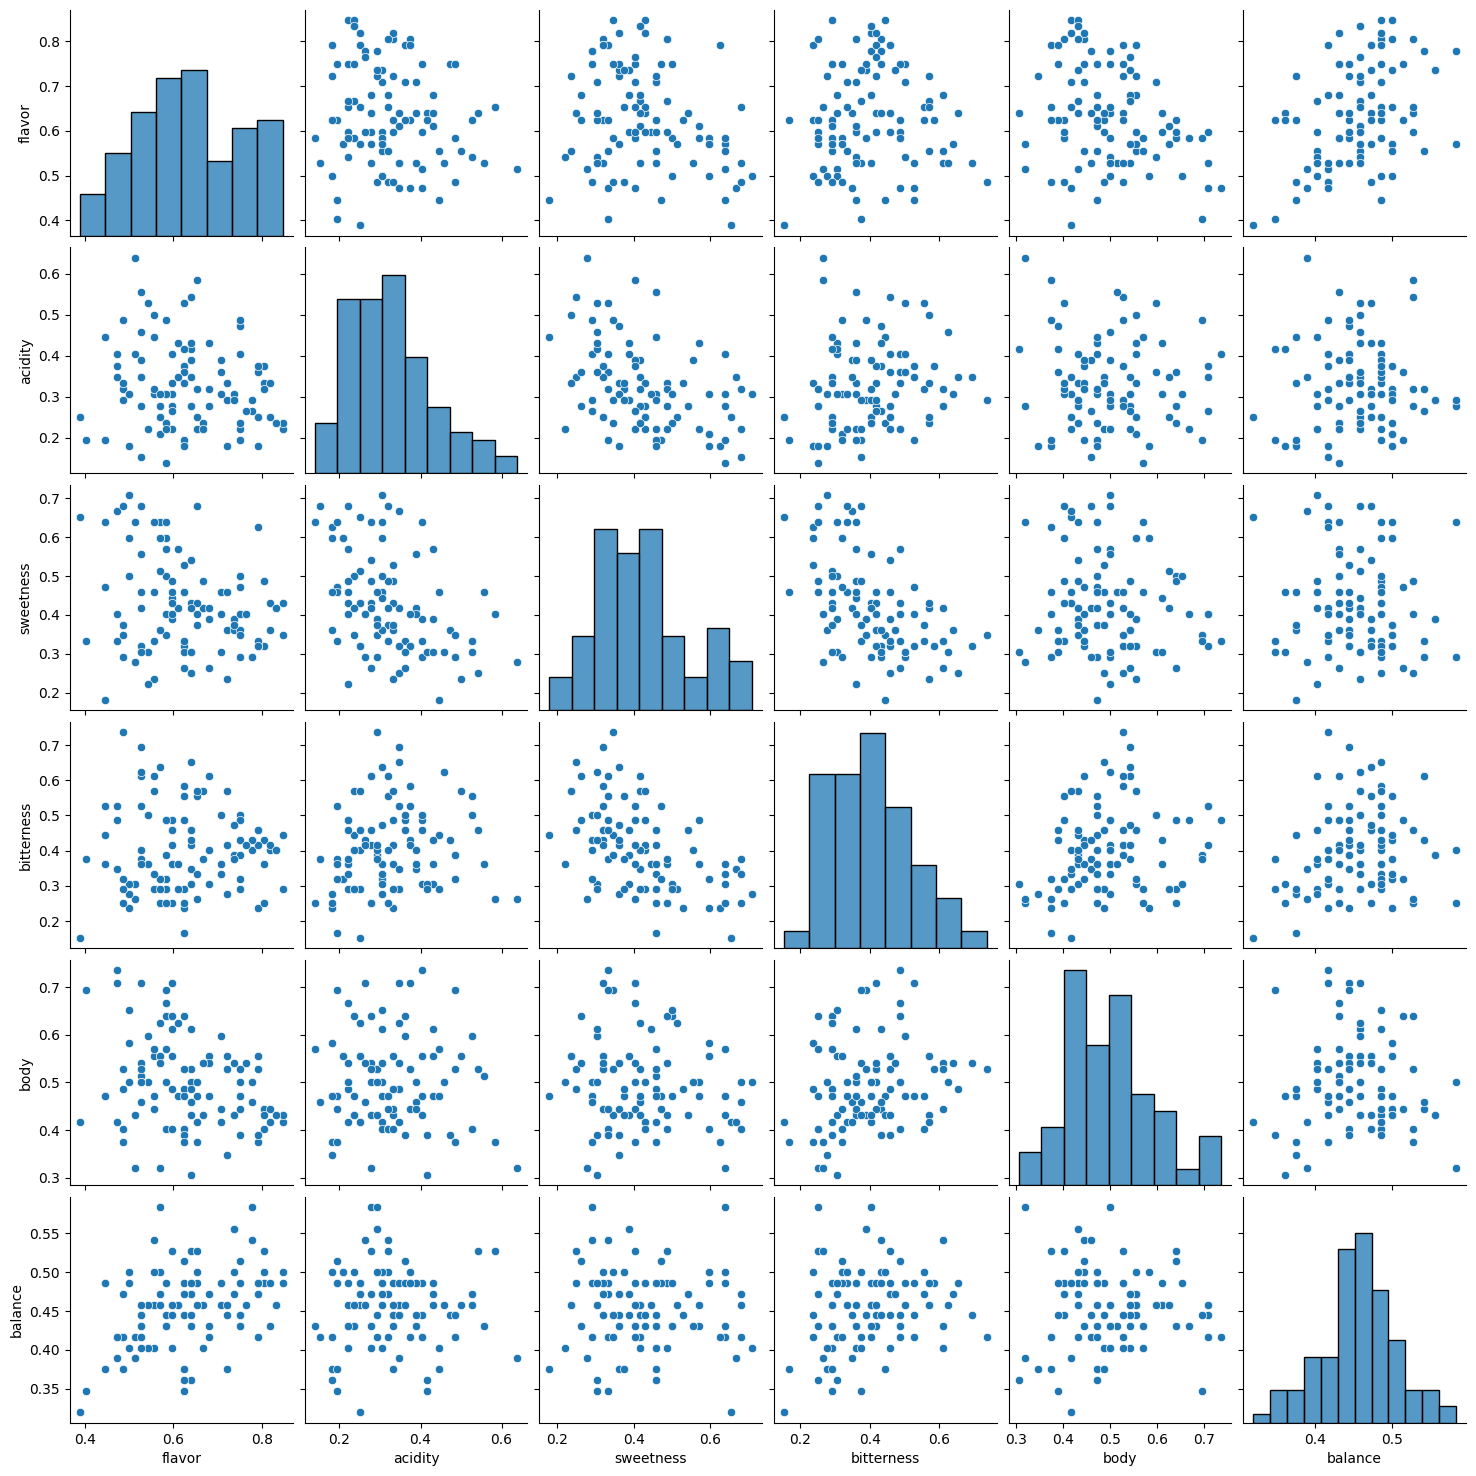

In [42]:
sns.pairplot(user_label_tf_df)

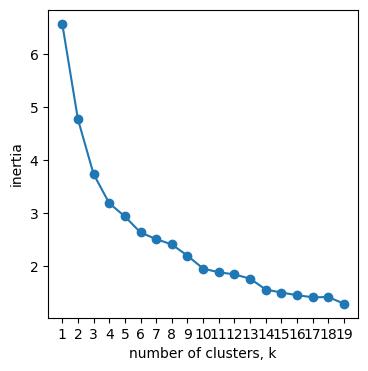

In [43]:
from sklearn.cluster import KMeans
# 적절한 군집수 찾기
# Inertia(군집 내 거리제곱합의 합) value (적정 군집수)

ks = range(1,20)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k, n_init='auto')
    model.fit(user_label_tf_df)
    inertias.append(model.inertia_)

# Plot ks vs inertias
plt.figure(figsize=(4, 4))

plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [44]:
# K-Means 모델과 군집 예측값을 생성

# 클러스터 모델 생성 파라미터는 원할 경우 추가
clust_model = KMeans(n_clusters = 6, n_init='auto'
#                      , max_iter=500 # KMeans를 몇번 반복 수행할건지, K가 큰 경우 1000정도로 높여준다
#                      , random_state = 42
#                      , algorithm='auto'
                    )

# 생성한 모델로 데이터를 학습시킴
clust_model.fit(user_label_tf_df) # unsupervised learning 

# 결과 값을 변수에 저장
centers = clust_model.cluster_centers_ # 각 군집의 중심점
pred = clust_model.predict(user_label_tf_df) # 각 예측군집

print(pd.DataFrame(centers))
print(pred[:10])

          0         1         2         3         4         5
0  0.593750  0.324653  0.350694  0.599826  0.486979  0.465278
1  0.537037  0.293519  0.630556  0.334259  0.446296  0.448148
2  0.566358  0.260802  0.485340  0.324846  0.594136  0.445216
3  0.746528  0.332465  0.373698  0.399306  0.460069  0.472656
4  0.554688  0.442708  0.305556  0.442708  0.569444  0.442708
5  0.739583  0.213542  0.473958  0.260417  0.413194  0.435764
[3 2 3 4 1 4 5 3 0 0]


In [45]:
# 원래 데이터에 예측된 군집 붙이기
user_label_tf_clust_df = user_label_tf_df.copy()
user_label_tf_clust_df['clust'] = pred
user_label_tf_clust_df.head()

flavor   acidity  sweetness  bitterness      body   balance  clust
0  0.833333  0.236111   0.416667    0.402778  0.430556  0.458333      3
1  0.500000  0.180556   0.597222    0.236111  0.583333  0.500000      2
2  0.805556  0.375000   0.319444    0.430556  0.444444  0.500000      3
3  0.472222  0.402778   0.333333    0.486111  0.736111  0.416667      4
4  0.569444  0.277778   0.638889    0.250000  0.319444  0.583333      1

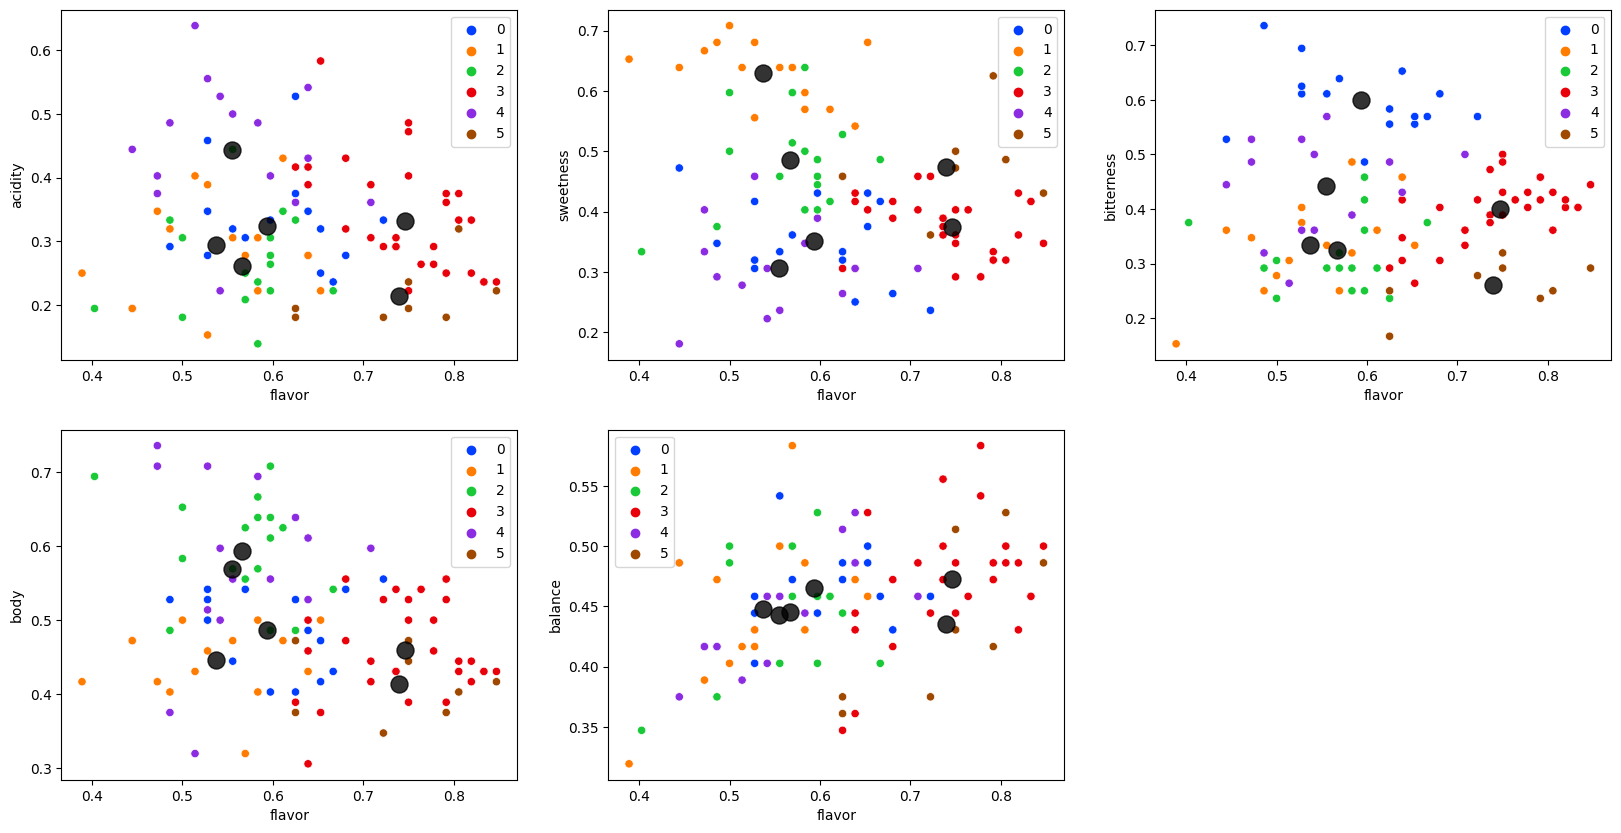

In [46]:
# scaling하지 않은 데이터를 학습하고 시각화하기

plt.figure(figsize=(20,10))

X = user_label_tf_clust_df

plt.subplot(231)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,1], data=user_label, hue=clust_model.labels_, palette='bright')
plt.scatter(centers[:,0], centers[:,1], c='black', alpha=0.8, s=150)

plt.subplot(232)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,2], data=user_label, hue=clust_model.labels_, palette='bright')
plt.scatter(centers[:,0], centers[:,2], c='black', alpha=0.8, s=150)

plt.subplot(233)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,3], data=user_label, hue=clust_model.labels_, palette='bright')
plt.scatter(centers[:,0], centers[:,3], c='black', alpha=0.8, s=150)

plt.subplot(234)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,4], data=user_label, hue=clust_model.labels_, palette='bright')
plt.scatter(centers[:,0], centers[:,4], c='black', alpha=0.8, s=150)

plt.subplot(235)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,5], data=user_label, hue=clust_model.labels_, palette='bright')
plt.scatter(centers[:,0], centers[:,5], c='black', alpha=0.8, s=150)

plt.show()

In [47]:
cluster_mean = user_label_tf_clust_df.groupby('clust').mean()
cluster_mean

flavor   acidity  sweetness  bitterness      body   balance
clust                                                               
0      0.593750  0.324653   0.350694    0.599826  0.486979  0.465278
1      0.537037  0.293519   0.630556    0.334259  0.446296  0.448148
2      0.566358  0.260802   0.485340    0.324846  0.594136  0.445216
3      0.746528  0.332465   0.373698    0.399306  0.460069  0.472656
4      0.554688  0.442708   0.305556    0.442708  0.569444  0.442708
5      0.739583  0.213542   0.473958    0.260417  0.413194  0.435764

In [48]:
standard_scaler = StandardScaler()
scaled_df = pd.DataFrame(standard_scaler.fit_transform(user_label_tf_df.iloc[:,:]), columns=user_label_tf_df.iloc[:,:].columns) # scaled된 데이터

In [49]:
# create model and prediction
# clust_model은 스케일링 전 fit과 동일하게 맞춤

clust_model.fit(scaled_df) # unsupervised learning #애초에 결과를 모르기 때문에 data만 넣어주면 됨

centers_s = clust_model.cluster_centers_
pred_s = clust_model.predict(scaled_df)

In [50]:
# 스케일링 전에 합쳐준 데이터프레임에 스케일한 군집 컬럼 추가하기
user_label_tf_clust_df['clust_s'] = pred_s
user_label_tf_clust_df

flavor   acidity  sweetness  bitterness      body   balance  clust  \
0    0.833333  0.236111   0.416667    0.402778  0.430556  0.458333      3   
1    0.500000  0.180556   0.597222    0.236111  0.583333  0.500000      2   
2    0.805556  0.375000   0.319444    0.430556  0.444444  0.500000      3   
3    0.472222  0.402778   0.333333    0.486111  0.736111  0.416667      4   
4    0.569444  0.277778   0.638889    0.250000  0.319444  0.583333      1   
..        ...       ...        ...         ...       ...       ...    ...   
100  0.486111  0.486111   0.291667    0.319444  0.375000  0.416667      4   
101  0.527778  0.458333   0.305556    0.625000  0.500000  0.458333      0   
102  0.472222  0.375000   0.402778    0.527778  0.708333  0.416667      4   
103  0.638889  0.430556   0.305556    0.430556  0.611111  0.486111      4   
104  0.736111  0.291667   0.375000    0.375000  0.430556  0.500000      3   

     clust_s  
0          2  
1          4  
2          2  
3          1  
4          4  
..       ...  
100        0  
101        5  
102        1  
103        1  
104        2  

[105 rows x 8 columns]

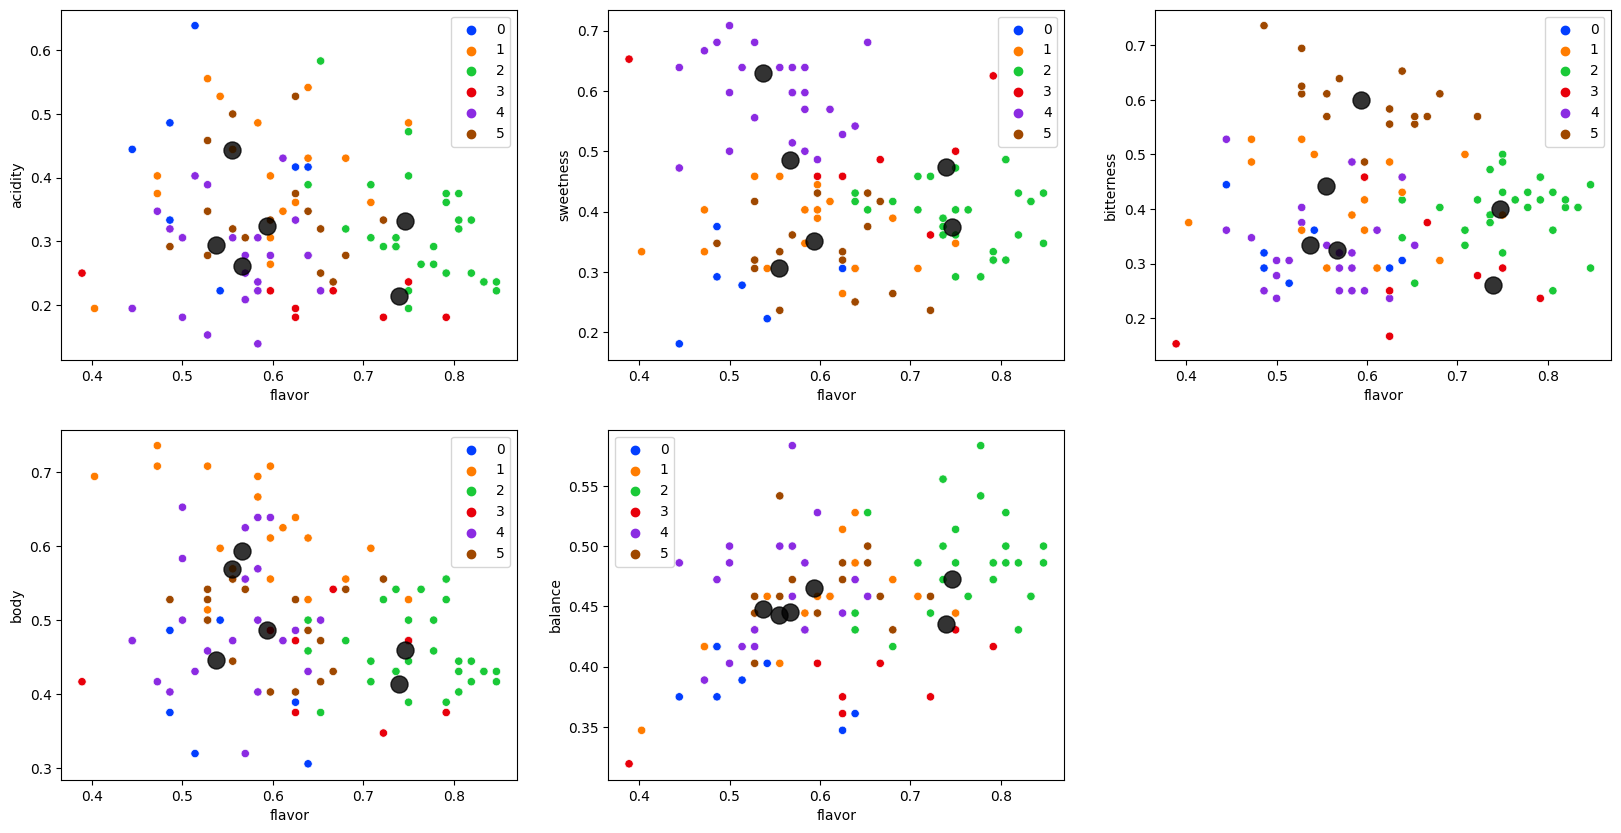

In [51]:
# scaling한 데이터를 학습하고 시각화하기

plt.figure(figsize=(20,10))

X = user_label_tf_clust_df

plt.subplot(231)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,1], data=user_label, hue=clust_model.labels_, palette='bright')
plt.scatter(centers[:,0], centers[:,1], c='black', alpha=0.8, s=150)

plt.subplot(232)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,2], data=user_label, hue=clust_model.labels_, palette='bright')
plt.scatter(centers[:,0], centers[:,2], c='black', alpha=0.8, s=150)

plt.subplot(233)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,3], data=user_label, hue=clust_model.labels_, palette='bright')
plt.scatter(centers[:,0], centers[:,3], c='black', alpha=0.8, s=150)

plt.subplot(234)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,4], data=user_label, hue=clust_model.labels_, palette='bright')
plt.scatter(centers[:,0], centers[:,4], c='black', alpha=0.8, s=150)

plt.subplot(235)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,5], data=user_label, hue=clust_model.labels_, palette='bright')
plt.scatter(centers[:,0], centers[:,5], c='black', alpha=0.8, s=150)

plt.show()

In [52]:
# 데이터 증식

user_label_tf_df_1k = user_label_tf_df.copy()
for i in range(10):
    user_label_tf_df_1k = pd.concat([user_label_tf_df_1k, user_label_tf_df], ignore_index=True)
    
user_label_tf_df_1k

flavor   acidity  sweetness  bitterness      body   balance
0     0.833333  0.236111   0.416667    0.402778  0.430556  0.458333
1     0.500000  0.180556   0.597222    0.236111  0.583333  0.500000
2     0.805556  0.375000   0.319444    0.430556  0.444444  0.500000
3     0.472222  0.402778   0.333333    0.486111  0.736111  0.416667
4     0.569444  0.277778   0.638889    0.250000  0.319444  0.583333
...        ...       ...        ...         ...       ...       ...
1150  0.486111  0.486111   0.291667    0.319444  0.375000  0.416667
1151  0.527778  0.458333   0.305556    0.625000  0.500000  0.458333
1152  0.472222  0.375000   0.402778    0.527778  0.708333  0.416667
1153  0.638889  0.430556   0.305556    0.430556  0.611111  0.486111
1154  0.736111  0.291667   0.375000    0.375000  0.430556  0.500000

[1155 rows x 6 columns]

In [53]:
np.random.uniform(low=0, high=10, size=1)

array([5.43483922])

In [54]:
user_label_tf_df_1k['flavor'] = user_label_tf_df_1k['flavor'].apply(lambda x: np.random.uniform(low=x-0.04, high=x+0.04, size=1)[0])
user_label_tf_df_1k['acidity'] = user_label_tf_df_1k['acidity'].apply(lambda x: np.random.uniform(low=x-0.04, high=x+0.04, size=1)[0])
user_label_tf_df_1k['sweetness'] = user_label_tf_df_1k['sweetness'].apply(lambda x: np.random.uniform(low=x-0.04, high=x+0.04, size=1)[0])
user_label_tf_df_1k['bitterness'] = user_label_tf_df_1k['bitterness'].apply(lambda x: np.random.uniform(low=x-0.04, high=x+0.04, size=1)[0])
user_label_tf_df_1k['body'] = user_label_tf_df_1k['body'].apply(lambda x: np.random.uniform(low=x-0.04, high=x+0.04, size=1)[0])
user_label_tf_df_1k['balance'] = user_label_tf_df_1k['balance'].apply(lambda x: np.random.uniform(low=x-0.04, high=x+0.04, size=1)[0])
user_label_tf_df_1k

flavor   acidity  sweetness  bitterness      body   balance
0     0.821410  0.264180   0.430877    0.387149  0.420226  0.473527
1     0.482658  0.215633   0.605867    0.257687  0.617774  0.490447
2     0.801571  0.387654   0.350204    0.399127  0.429356  0.490002
3     0.505392  0.399602   0.355075    0.508637  0.750270  0.443938
4     0.587580  0.303133   0.643639    0.269388  0.352682  0.609941
...        ...       ...        ...         ...       ...       ...
1150  0.450934  0.491779   0.257473    0.351058  0.338783  0.404266
1151  0.496464  0.422382   0.291273    0.606030  0.536100  0.424529
1152  0.438576  0.360816   0.392727    0.513338  0.688984  0.391103
1153  0.645599  0.405443   0.332355    0.448812  0.601841  0.493388
1154  0.770853  0.331547   0.355891    0.413013  0.465872  0.530400

[1155 rows x 6 columns]

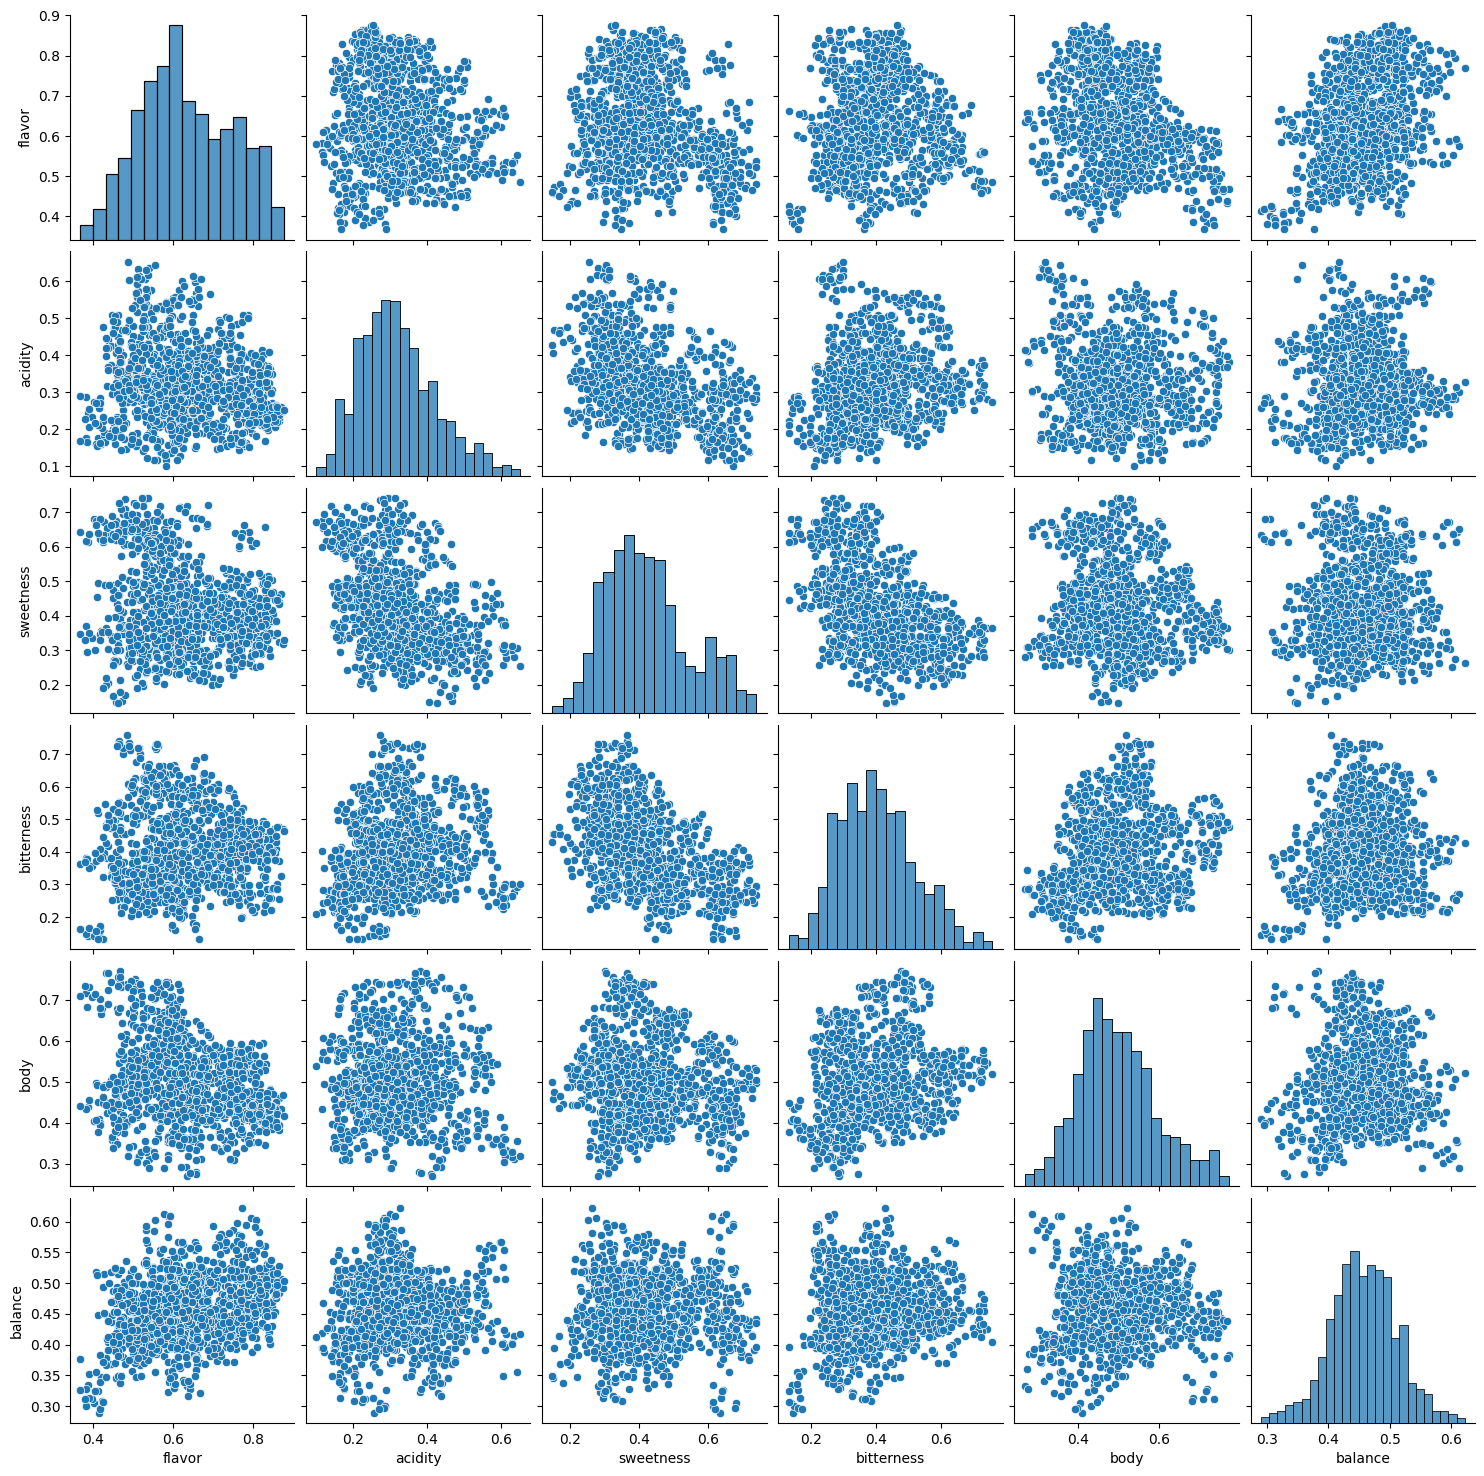

In [55]:
sns.pairplot(user_label_tf_df_1k)

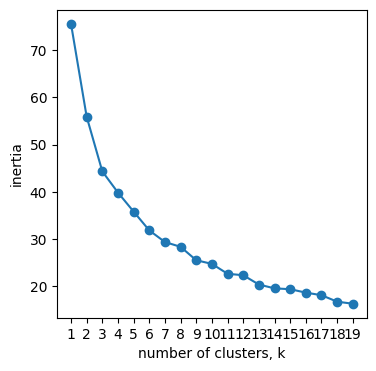

In [56]:
from sklearn.cluster import KMeans
# 적절한 군집수 찾기
# Inertia(군집 내 거리제곱합의 합) value (적정 군집수)

ks = range(1,20)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k, n_init='auto')
    model.fit(user_label_tf_df_1k)
    inertias.append(model.inertia_)

# Plot ks vs inertias
plt.figure(figsize=(4, 4))

plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [57]:
# K-Means 모델과 군집 예측값을 생성

# 클러스터 모델 생성 파라미터는 원할 경우 추가
clust_model = KMeans(n_clusters = 6, n_init='auto'
#                      , max_iter=500 # KMeans를 몇번 반복 수행할건지, K가 큰 경우 1000정도로 높여준다
#                      , random_state = 42
#                      , algorithm='auto'
                    )

# 생성한 모델로 데이터를 학습시킴
clust_model.fit(user_label_tf_df_1k) # unsupervised learning 

# 결과 값을 변수에 저장
centers = clust_model.cluster_centers_ # 각 군집의 중심점
pred = clust_model.predict(user_label_tf_df_1k) # 각 예측군집

print(pd.DataFrame(centers))
print(pred[:10])

          0         1         2         3         4         5
0  0.597979  0.303572  0.480617  0.344199  0.534465  0.442548
1  0.775273  0.288256  0.386831  0.397675  0.460375  0.484817
2  0.602138  0.499662  0.322437  0.373318  0.424330  0.433231
3  0.543190  0.348200  0.335421  0.455221  0.662634  0.437405
4  0.546013  0.244993  0.634904  0.288187  0.460791  0.452378
5  0.600612  0.334172  0.336322  0.599109  0.500513  0.463132
[1 4 1 3 4 5 1 1 0 5]


In [58]:
# 원래 데이터에 예측된 군집 붙이기
user_label_tf_clust_df_1k = user_label_tf_df_1k.copy()
user_label_tf_clust_df_1k['clust'] = pred
user_label_tf_clust_df_1k.head()

flavor   acidity  sweetness  bitterness      body   balance  clust
0  0.821410  0.264180   0.430877    0.387149  0.420226  0.473527      1
1  0.482658  0.215633   0.605867    0.257687  0.617774  0.490447      4
2  0.801571  0.387654   0.350204    0.399127  0.429356  0.490002      1
3  0.505392  0.399602   0.355075    0.508637  0.750270  0.443938      3
4  0.587580  0.303133   0.643639    0.269388  0.352682  0.609941      4

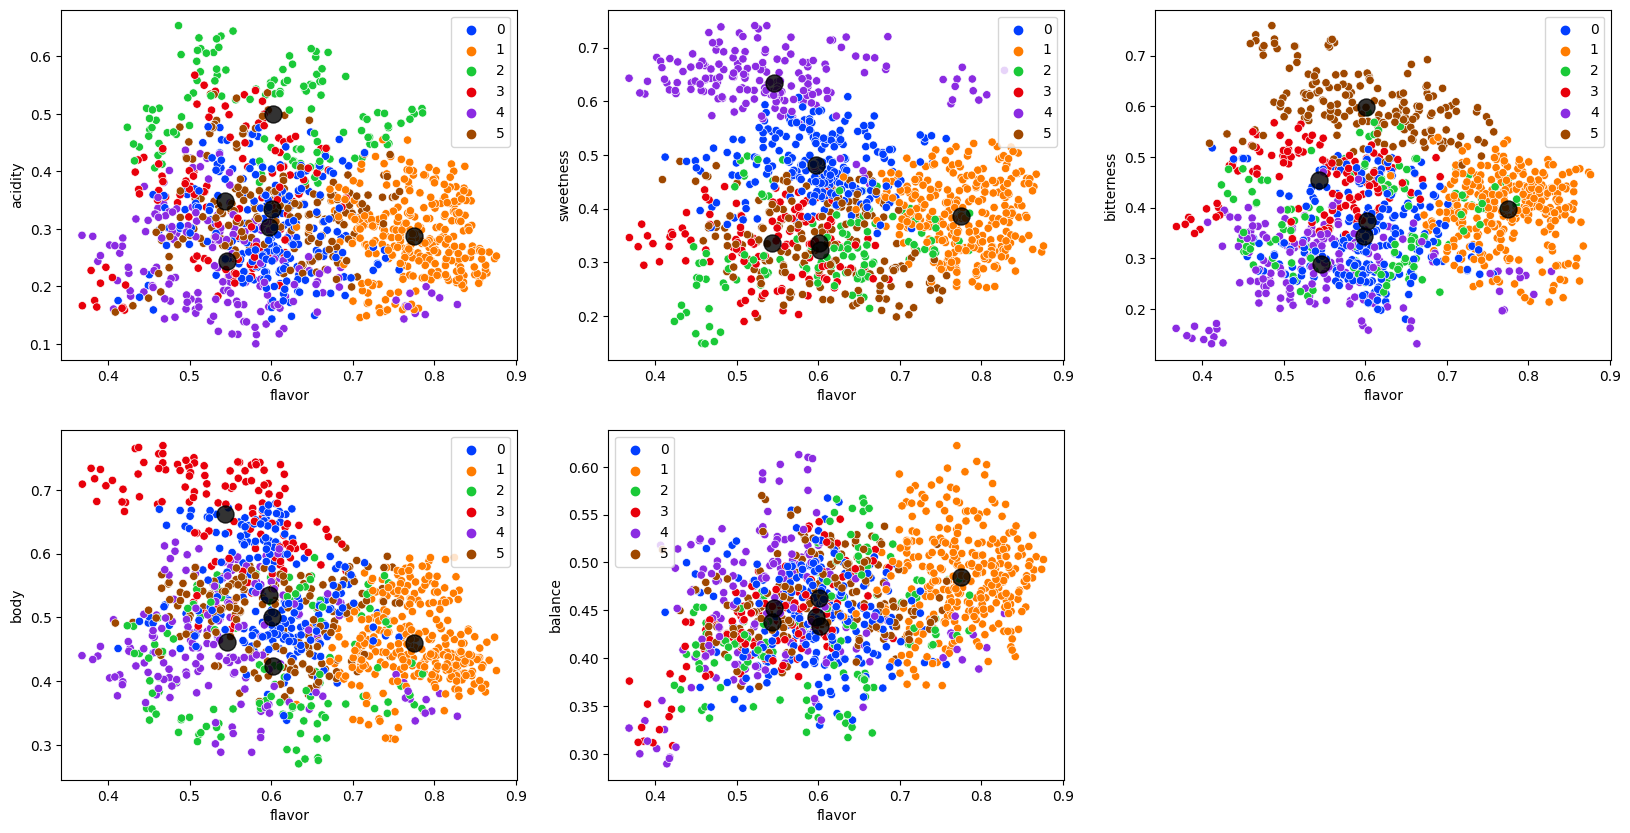

In [59]:
# scaling하지 않은 데이터를 학습하고 시각화하기

plt.figure(figsize=(20,10))

X = user_label_tf_clust_df_1k

plt.subplot(231)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,1], data=user_label_tf_df_1k, hue=clust_model.labels_, palette='bright')
plt.scatter(centers[:,0], centers[:,1], c='black', alpha=0.8, s=150)

plt.subplot(232)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,2], data=user_label_tf_df_1k, hue=clust_model.labels_, palette='bright')
plt.scatter(centers[:,0], centers[:,2], c='black', alpha=0.8, s=150)

plt.subplot(233)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,3], data=user_label_tf_df_1k, hue=clust_model.labels_, palette='bright')
plt.scatter(centers[:,0], centers[:,3], c='black', alpha=0.8, s=150)

plt.subplot(234)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,4], data=user_label_tf_df_1k, hue=clust_model.labels_, palette='bright')
plt.scatter(centers[:,0], centers[:,4], c='black', alpha=0.8, s=150)

plt.subplot(235)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,5], data=user_label_tf_df_1k, hue=clust_model.labels_, palette='bright')
plt.scatter(centers[:,0], centers[:,5], c='black', alpha=0.8, s=150)

plt.show()

In [60]:
cluster_mean_1k = user_label_tf_clust_df_1k.groupby('clust').mean()
cluster_mean_1k

flavor   acidity  sweetness  bitterness      body   balance
clust                                                               
0      0.597979  0.303572   0.480617    0.344199  0.534465  0.442548
1      0.775273  0.288256   0.386831    0.397675  0.460375  0.484817
2      0.602138  0.499662   0.322437    0.373318  0.424330  0.433231
3      0.543190  0.348200   0.335421    0.455221  0.662634  0.437405
4      0.546013  0.244993   0.634904    0.288187  0.460791  0.452378
5      0.600612  0.334172   0.336322    0.599109  0.500513  0.463132

In [61]:
standard_scaler = StandardScaler()
scaled_df = pd.DataFrame(standard_scaler.fit_transform(user_label_tf_df_1k.iloc[:,:]), columns=user_label_tf_df_1k.iloc[:,:].columns) # scaled된 데이터

In [62]:
# create model and prediction
# clust_model은 스케일링 전 fit과 동일하게 맞춤

clust_model.fit(scaled_df) # unsupervised learning #애초에 결과를 모르기 때문에 data만 넣어주면 됨

centers_s = clust_model.cluster_centers_
pred_s = clust_model.predict(scaled_df)

In [63]:
# 스케일링 전에 합쳐준 데이터프레임에 스케일한 군집 컬럼 추가하기
user_label_tf_clust_df_1k['clust_s'] = pred_s
user_label_tf_clust_df_1k

flavor   acidity  sweetness  bitterness      body   balance  clust  \
0     0.821410  0.264180   0.430877    0.387149  0.420226  0.473527      1   
1     0.482658  0.215633   0.605867    0.257687  0.617774  0.490447      4   
2     0.801571  0.387654   0.350204    0.399127  0.429356  0.490002      1   
3     0.505392  0.399602   0.355075    0.508637  0.750270  0.443938      3   
4     0.587580  0.303133   0.643639    0.269388  0.352682  0.609941      4   
...        ...       ...        ...         ...       ...       ...    ...   
1150  0.450934  0.491779   0.257473    0.351058  0.338783  0.404266      2   
1151  0.496464  0.422382   0.291273    0.606030  0.536100  0.424529      5   
1152  0.438576  0.360816   0.392727    0.513338  0.688984  0.391103      3   
1153  0.645599  0.405443   0.332355    0.448812  0.601841  0.493388      3   
1154  0.770853  0.331547   0.355891    0.413013  0.465872  0.530400      1   

      clust_s  
0           1  
1           5  
2           1  
3           4  
4           5  
...       ...  
1150        3  
1151        2  
1152        4  
1153        2  
1154        1  

[1155 rows x 8 columns]

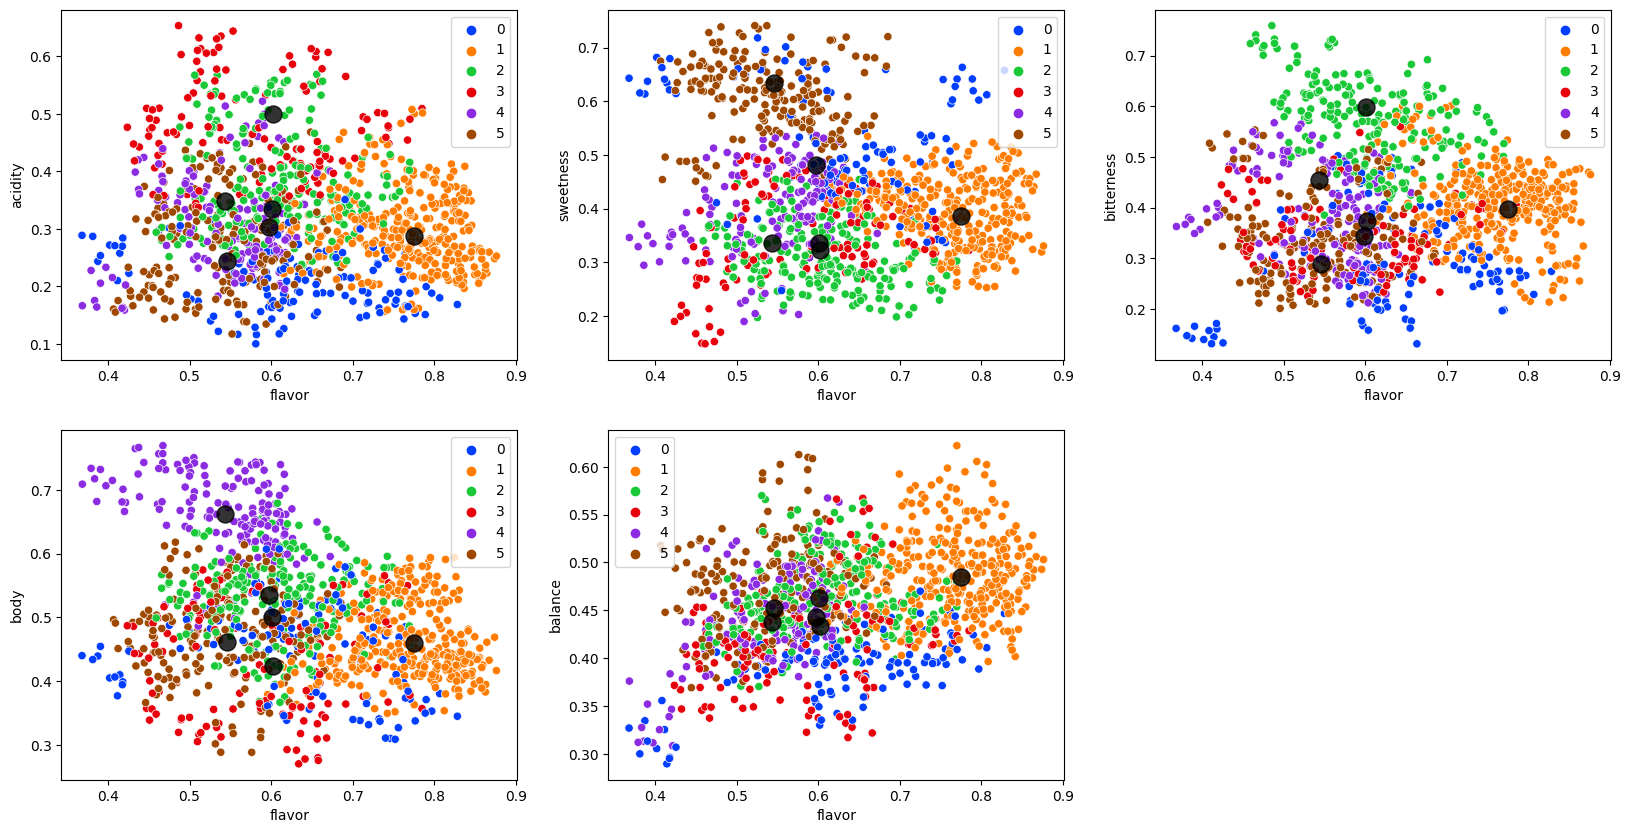

In [78]:
# scaling한 데이터를 학습하고 시각화하기

plt.figure(figsize=(20,10))

X = user_label_tf_clust_df_1k

plt.subplot(231)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,1], data=user_label_tf_df_1k, hue=clust_model.labels_, palette='bright')
plt.scatter(centers[:,0], centers[:,1], c='black', alpha=0.8, s=150)

plt.subplot(232)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,2], data=user_label_tf_df_1k, hue=clust_model.labels_, palette='bright')
plt.scatter(centers[:,0], centers[:,2], c='black', alpha=0.8, s=150)

plt.subplot(233)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,3], data=user_label_tf_df_1k, hue=clust_model.labels_, palette='bright')
plt.scatter(centers[:,0], centers[:,3], c='black', alpha=0.8, s=150)

plt.subplot(234)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,4], data=user_label_tf_df_1k, hue=clust_model.labels_, palette='bright')
plt.scatter(centers[:,0], centers[:,4], c='black', alpha=0.8, s=150)

plt.subplot(235)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,5], data=user_label_tf_df_1k, hue=clust_model.labels_, palette='bright')
plt.scatter(centers[:,0], centers[:,5], c='black', alpha=0.8, s=150)

plt.show()

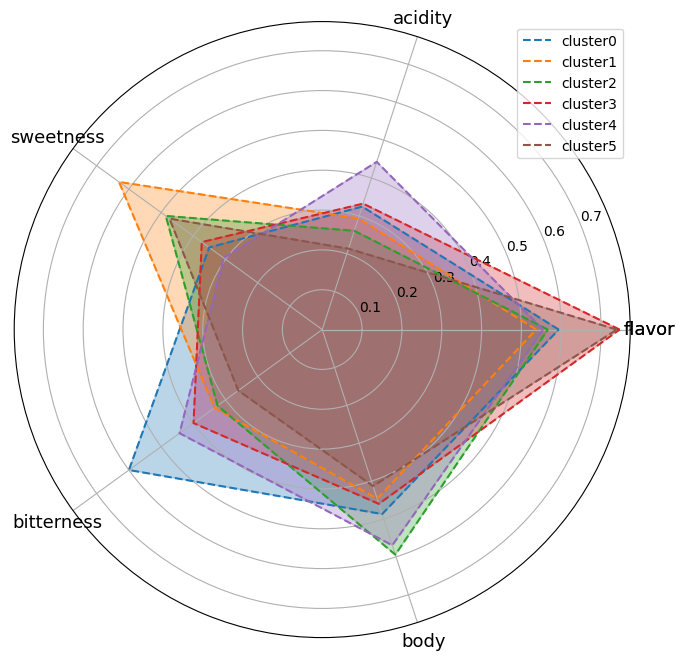

In [89]:
# radar로 cluster_k_mean 출력

categories = cluster_mean.columns[:-1]
categories = [*categories, categories[0]]

cluster = cluster_mean.apply(lambda x : [*list(x)[:-1], list(x)[0]], axis=1)

label_loc = np.linspace(start=0, stop=2*np.pi, num=len(cluster[0]))

plt.figure(figsize=(8, 8))
ax = plt.subplot(polar=True)
plt.xticks(label_loc, labels=categories, fontsize=13)
plt.color_sequences
ax.plot(label_loc, cluster[0], label='cluster0', linestyle='dashed', color='tab:blue')
ax.fill(label_loc, cluster[0], color='tab:blue', alpha=0.3)
ax.plot(label_loc, cluster[1], label='cluster1', linestyle='dashed', color='tab:orange')
ax.fill(label_loc, cluster[1], color='tab:orange', alpha=0.3)
ax.plot(label_loc, cluster[2], label='cluster2', linestyle='dashed', color='tab:green')
ax.fill(label_loc, cluster[2], color='tab:green', alpha=0.3)
ax.plot(label_loc, cluster[3], label='cluster3', linestyle='dashed', color='tab:red')
ax.fill(label_loc, cluster[3], color='tab:red', alpha=0.3)
ax.plot(label_loc, cluster[4], label='cluster4', linestyle='dashed', color='tab:purple')
ax.fill(label_loc, cluster[4], color='tab:purple', alpha=0.3)
ax.plot(label_loc, cluster[5], label='cluster5', linestyle='dashed', color='tab:brown')
ax.fill(label_loc, cluster[5], color='tab:brown', alpha=0.3)
ax.legend()
plt.show()

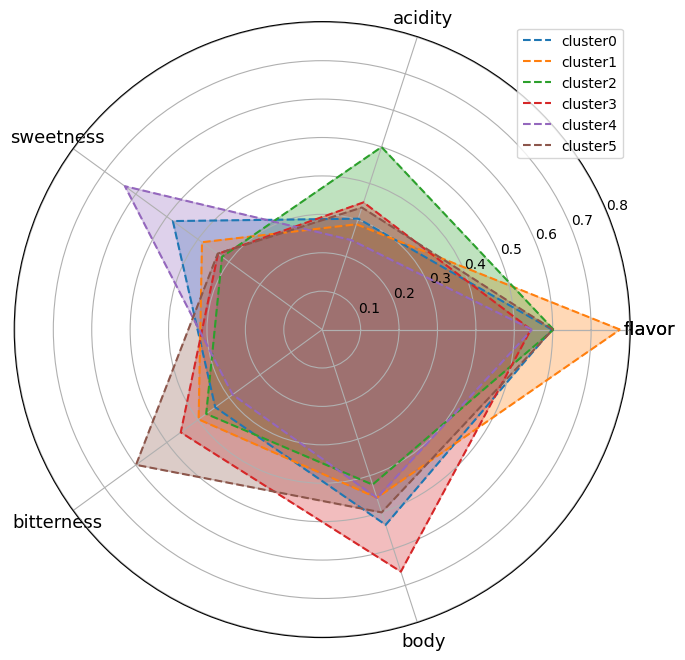

In [92]:
# radar로 cluster_k_mean_1k 출력

categories = cluster_mean_1k.columns[:-1]
categories = [*categories, categories[0]]

cluster = cluster_mean_1k.apply(lambda x : [*list(x)[:-1], list(x)[0]], axis=1)

label_loc = np.linspace(start=0, stop=2*np.pi, num=len(cluster[0]))

plt.figure(figsize=(8, 8))
ax = plt.subplot(polar=True)
plt.xticks(label_loc, labels=categories, fontsize=13)
plt.color_sequences
ax.plot(label_loc, cluster[0], label='cluster0', linestyle='dashed', color='tab:blue')
ax.fill(label_loc, cluster[0], color='tab:blue', alpha=0.3)
ax.plot(label_loc, cluster[1], label='cluster1', linestyle='dashed', color='tab:orange')
ax.fill(label_loc, cluster[1], color='tab:orange', alpha=0.3)
ax.plot(label_loc, cluster[2], label='cluster2', linestyle='dashed', color='tab:green')
ax.fill(label_loc, cluster[2], color='tab:green', alpha=0.3)
ax.plot(label_loc, cluster[3], label='cluster3', linestyle='dashed', color='tab:red')
ax.fill(label_loc, cluster[3], color='tab:red', alpha=0.3)
ax.plot(label_loc, cluster[4], label='cluster4', linestyle='dashed', color='tab:purple')
ax.fill(label_loc, cluster[4], color='tab:purple', alpha=0.3)
ax.plot(label_loc, cluster[5], label='cluster5', linestyle='dashed', color='tab:brown')
ax.fill(label_loc, cluster[5], color='tab:brown', alpha=0.3)
ax.legend()
plt.show()